# EE6310 - Image and Video Processing
Homework-4

## Imports

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
np.random.seed(3)
import warnings
warnings.filterwarnings('ignore')
!pip3 install tqdm
from tqdm import tqdm


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Dataset

**Assumptions:**
- Variance of Gaussian Noise ($\sigma^2$) = 0.0001
- No.of samples in dataset ($N$) = 1000
- No.of training samples = 0.8 $\times $ N = 800
- No.of validation smaples = 0.2 $\times $ N = 200

### Functions
- Function that perturbs the inputs
- Function that splits dataset to training and validation datasets
- Function that generates inputs

#### Function that perturbs the inputs

In [2]:
def PerturbInput(X):
	# Parameters of Gaussian Noise
	mu = 0
	sigma = np.sqrt(0.0001)

	Noise = np.random.normal(loc=mu, scale=sigma, size=X.shape)
	X_Perturbed = X + Noise

	return X_Perturbed

#### Function that splits dataset to training and validation datasets

In [3]:
def SplitData(X,y,SplitRatio):
	"""
	SplitRatio: Percentage of validation samples.
	"""
	assert(X.shape[0] == y.shape[0])

	N = X.shape[0]
	TrainIndices = np.random.choice(N, size=int(N*(1-SplitRatio)), replace=False)
	ValidIndices = np.array(list(set(np.arange(N)) - set(TrainIndices)))

	X_Train, y_Train = X[TrainIndices], y[TrainIndices]
	X_Valid, y_Valid = X[ValidIndices], y[ValidIndices]

	return X_Train, y_Train, X_Valid, y_Valid	

#### Function that generates inputs

In [4]:
def GenerateDatasets(N,Operator,SplitRatio):
	"""
	N: No.of Samples
    Operator: Boolean Operation
    """
	X = np.round(np.random.uniform(0,1,(N,2)))

	if Operator == 'AND':
		y = np.logical_and(np.round(X[:,0]),np.round(X[:,1])).astype(int)

	if Operator == 'OR':
		y = np.logical_or(np.round(X[:,0]),np.round(X[:,1])).astype(int)

	if Operator == 'XOR':
		y = np.logical_xor(np.round(X[:,0]),np.round(X[:,1])).astype(int)

	return SplitData(PerturbInput(X), y,SplitRatio)

## Multilayer Perceptron Model
Building a Multilayer Perceptron Model. We consider only one hidden layer.

### Specifications:
1. **Input Nodes**: L (Changes dynamically with according to inputs).
2. **Hidden Layers**: 1
3. **Nodes in Hidden Layer**: M
4. **Output Nodes**: K (Changes dynamically with according to targets).
5. **Activation Function ($\sigma$)**: Sigmoid
6. **Loss Function**: SE(Squared Error)
7. **Optimizer**: Batch Gradient Descent with batch_size = $k$ and learning_rate = $\alpha$

---

### Forward Propagation:
$\begin{align*}
	A_1 = XW_1 + b_1 \\
	H_1 = \sigma(A_1) \\
	A_2 = H_1W_2 + b_2 \\
	\hat{Y} = H_2 = \sigma(A_2)
\end{align*}$

### Activation Function:
$\begin{align*}
    \sigma(x) = \frac{1}{1 + e^{-x}}
\end{align*}$

### Loss Function:
$\begin{align*}
    L = \frac{1}{k}\|Y - \hat{Y}\|^2 
\end{align*}$

### Back Propagation:
$\begin{align*}
    \frac{\partial{L}}{\partial{H_2}} = \frac{2}{k}(H_2 - Y)\\
    \frac{\partial{L}}{\partial{A_2}} = \frac{\partial{L}}{\partial{H_2}} \odot \sigma(A_2)(1-\sigma(A_2)) = \frac{\partial{L}}{\partial{H_2}} \odot H_2(1-H_2) \\
    \frac{\partial{L}}{\partial{W_2}} = H_1^T \frac{\partial{L}}{\partial{A_2}} \\
    \frac{\partial{L}}{\partial{b_2}} = \sum \frac{\partial{L}}{\partial{A_2}} \\
    \\
    \frac{\partial{L}}{\partial{H_1}} = \frac{\partial{L}}{\partial{A_2}}W_2^T\\
    \frac{\partial{L}}{\partial{A_1}} = \frac{\partial{L}}{\partial{H_1}} \odot \sigma(A_1)(1-\sigma(A_1)) = \frac{\partial{L}}{\partial{H_1}} \odot H_1(1-H_1) \\
    \frac{\partial{L}}{\partial{W_1}} = X^T \frac{\partial{L}}{\partial{A_1}} \\
    \frac{\partial{L}}{\partial{b_1}} = \sum \frac{\partial{L}}{\partial{A_1}}
\end{align*}$

### Update Parameters:

$\begin{align*}
    W_2 = W_2 - \alpha(\frac{\partial{L}}{\partial{W_2}})\\
    b_2 = b_2 - \alpha(\frac{\partial{L}}{\partial{b_2}})\\
    W_1 = W_1 - \alpha(\frac{\partial{L}}{\partial{W_1}})\\
    b_1 = b_1 - \alpha(\frac{\partial{L}}{\partial{b_1}})
\end{align*}$


**Note**:
- The terms dP in code indicate $\frac{\partial{L}}{\partial{P}}$ i.e partial deravative of doss ($L$) wrt parameter ($P$).

In [5]:
class MLP:
	"""
	Considering no.of Hidden Layers = 1
	"""
	def __init__(self,M):
		# Model Specifications
		self.L = None
		self.M = M
		self.K = None
		self.N = None
		self.TrainLossData = []
		self.ValidLossData = []
		
		
	def PrintParameters(self):
		# Print all Parameters
		print ("self.W1", self.W1)
		print ("self.b1", self.b1)
		print ("self.A1", self.A1)
		print ("self.H1", self.H1)

		print ("self.W2", self.W2)
		print ("self.b2", self.b2)
		print ("self.A2", self.A2)
		print ("self.H2", self.H2)

		print ("self.dW1", self.dW1)
		print ("self.db1", self.db1)
		print ("self.dA1", self.dA1)
		print ("self.dH1", self.dH1)

		print ("self.dW2", self.dW2)
		print ("self.db2", self.db2)
		print ("self.dA2", self.dA2)
		print ("self.dH2", self.dH2)


	def InitializeParameters(self):
		# Model Parameters
		self.W1 = np.random.randn(self.L,self.M)
		self.b1 = np.random.randn(1,self.M)
		
		self.W2 = np.random.randn(self.M,self.K)
		self.b2 = np.random.randn(1,self.K)


	def ActivationFunction(self,I):
		# Sigmoid Activation Function
		return np.divide(1.0,(1.0 + np.exp(-I)))


	def GradientActivation(self,I):
		# Gradient of Sigmoid Activation Function where 'I' denotes output of sigmoid.
		return I * (1.0 - I)


	def Loss(self, y_true, y_pred):
		return (np.sum(np.square(y_true - y_pred))/y_true.shape[0])
		
		
	def ForwardPropagation(self,X):
		# Forward Propagation
		self.A1 = np.matmul(X,self.W1) + self.b1
		self.H1 = self.ActivationFunction(self.A1)
		self.A2 = np.matmul(self.H1,self.W2) + self.b2
		self.H2 = self.ActivationFunction(self.A2)
		
		return self.H2


	def BackPropagation(self, X, y_pred):
		# Back Propagation
		self.dH2 = 2*(self.H2 - y_pred)/y_pred.shape[0]
			
		self.dA2 = np.multiply(self.dH2, self.GradientActivation(self.H2))
		self.dW2 = np.matmul(self.H1.T, self.dA2)
		self.db2 = np.sum(self.dA2, axis=0).reshape(1,-1)
		
		self.dH1 = np.matmul(self.dA2,self.W2.T) 
		self.dA1 = np.multiply(self.dH1, self.GradientActivation(self.H1))
		self.dW1 = np.matmul(X.T, self.dA1)
		self.db1 = np.sum(self.dA1, axis=0).reshape(1,-1)
			
		
	def UpdateParameters(self):
		# Updating Parameters using Gradient Descent
		self.W1 -= (self.lr * self.dW1)
		self.b1 -= (self.lr * self.db1)

		self.W2 -= (self.lr * self.dW2)
		self.b2 -= (self.lr * self.db2)


	def step(self, X, y, batch_size, training):
		if training == True:
			description = "train_step"
		else:
			description = "valid_step"


		Steps = X.shape[0]//batch_size
		l = []
		for j in tqdm(range(Steps), desc=description, leave=True):
			if batch_size == 1:
				I = np.expand_dims(X[j],axis=0)
				O = np.expand_dims(y[j],axis=0)
			else:
				I = X[j*batch_size:(j+1)*batch_size]
				O = y[j*batch_size:(j+1)*batch_size]

			self.ForwardPropagation(I)
			l.append(self.Loss(O, self.H2))

			if training == True:
				self.BackPropagation(I,O)
				self.UpdateParameters()

		return np.round(np.mean(l), decimals=5)
		

	def fit(self, X_Train, y_Train, epochs, batch_size, lr, validation_data=None, shuffle=True, LoadWeights=False, LoadWeightsPath=None, SaveWeights=False, SaveWeightsPath=None):
		# Training the Model

		# Training Data
		self.X_Train = X_Train
		if len(y_Train.shape) == 1:
			self.y_Train = np.expand_dims(y_Train,axis=-1)
		else:
			self.y_Train = y_Train

		# Validation Data
		if validation_data != None:
			self.X_Valid = validation_data[0]
			if len(validation_data[1].shape) == 1:
				self.y_Valid = np.expand_dims(validation_data[1],axis=-1)
			else:
				self.y_Valid = validation_data[1]

		# Setting Model Architecture
		self.N = self.X_Train.shape[0]
		self.L = self.X_Train.shape[1]
		self.K = self.y_Train.shape[1]
		
		# Setting Learning Rate
		self.lr = lr
				
		# Initializing or Loading Weights
		if LoadWeights == False:
			self.InitializeParameters()
		elif LoadWeights == True and LoadWeightsPath == None:
			raise RuntimeError("No path provided to load weights")
		else:
			self.W1 = np.load(LoadWeightsPath + "/W1.npy")
			self.b1 = np.load(LoadWeightsPath + "/b1.npy")
			self.W2 = np.load(LoadWeightsPath + "/W2.npy")
			self.b2 = np.load(LoadWeightsPath + "/b2.npy")
		
		# Starting training the Model
		for i in range(epochs):
			if shuffle == True:
				ind = np.random.choice(self.N, size=self.N, replace=False)
				self.X_Train = self.X_Train[ind]
				self.y_Train = self.y_Train[ind]			

			# Training
			tl = self.step(self.X_Train, self.y_Train, batch_size, True)
			self.TrainLossData.append(tl)

			# Validation
			if validation_data != None:
				vl = self.step(self.X_Valid, self.y_Valid, batch_size, False)
				self.ValidLossData.append(vl)
			
			# Printing Results
			if validation_data != None:
				print ("Epoch: %-*s  loss: %-*s val_loss: %-*s" % (6,i+1,12,tl,12,vl))
			else:
				print ("Epoch: %-*s  loss: %-*s" % (6,i+1,18,tl))
			print ()

		# Saving Weights	
		if SaveWeightsPath != None and SaveWeights == True:
			np.save(SaveWeightsPath + "/W1.npy", self.W1)
			np.save(SaveWeightsPath + "/b1.npy", self.b1)
			np.save(SaveWeightsPath + "/W2.npy", self.W2)
			np.save(SaveWeightsPath + "/b2.npy", self.b2)


	def PlotLoss(self):
		# Plotting Loss
		plt.figure(figsize=(6,6))
		plt.plot(self.TrainLossData,'blue',label="Training Loss")
		if len(self.ValidLossData) > 0:
			plt.plot(self.ValidLossData,'orange',label="Validation Loss")
		plt.xlabel("Epochs")
		plt.ylabel("Loss")
		plt.title("Loss Function")
		plt.grid()
		plt.legend()
		plt.show()


	def loadWeights(self,LoadWeightsPath):
		# Load Weights of Model
		self.W1 = np.load(LoadWeightsPath + "/W1.npy")
		self.b1 = np.load(LoadWeightsPath + "/b1.npy")
		self.W2 = np.load(LoadWeightsPath + "/W2.npy")
		self.b2 = np.load(LoadWeightsPath + "/b2.npy")


	def predict(self,X):
		# Predicting from Data
		return self.ForwardPropagation(X)

## Q1

### 1a: XOR

- Generating Data
- Setting Training Parameters
- Creating Model

In [6]:
# Generating Data
X_Train, y_Train, X_Valid, y_Valid = GenerateDatasets(2500, "XOR", 0.2)

# Training Data
batch_size = 8
epochs = 100
lr = 0.05

# Creating Model
XOR_Model = MLP(2)

Training Model

In [7]:
XOR_Model.fit(
	X_Train,
	y_Train,
	epochs,
	batch_size,
	lr,
	(X_Valid, y_Valid)
)

valid_step: 100%|██████████| 62/62 [00:00<00:00, 27896.04it/s]


Epoch: 1       loss: 0.24383      val_loss: 0.24171     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 24210.67it/s]


Epoch: 2       loss: 0.24209      val_loss: 0.24021     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 25375.38it/s]


Epoch: 3       loss: 0.24073      val_loss: 0.2383      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 28842.82it/s]


Epoch: 4       loss: 0.23942      val_loss: 0.23786     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 27486.19it/s]


Epoch: 5       loss: 0.23767      val_loss: 0.23589     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 30957.96it/s]


Epoch: 6       loss: 0.23558      val_loss: 0.23433     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 30855.11it/s]


Epoch: 7       loss: 0.23358      val_loss: 0.231       



valid_step: 100%|██████████| 62/62 [00:00<00:00, 39460.83it/s]


Epoch: 8       loss: 0.23084      val_loss: 0.22824     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 36057.52it/s]


Epoch: 9       loss: 0.22776      val_loss: 0.22423     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 29042.53it/s]


Epoch: 10      loss: 0.22435      val_loss: 0.2205      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 36304.18it/s]


Epoch: 11      loss: 0.22038      val_loss: 0.21742     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 36354.93it/s]


Epoch: 12      loss: 0.2161       val_loss: 0.21135     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 39884.49it/s]


Epoch: 13      loss: 0.21138      val_loss: 0.20615     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 36964.73it/s]


Epoch: 14      loss: 0.20625      val_loss: 0.20152     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 39574.93it/s]


Epoch: 15      loss: 0.20067      val_loss: 0.19484     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 38935.00it/s]


Epoch: 16      loss: 0.19455      val_loss: 0.18903     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 36319.39it/s]


Epoch: 17      loss: 0.1884       val_loss: 0.18352     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 33101.69it/s]


Epoch: 18      loss: 0.18178      val_loss: 0.17571     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 22209.14it/s]


Epoch: 19      loss: 0.17454      val_loss: 0.16808     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 22429.43it/s]


Epoch: 20      loss: 0.16706      val_loss: 0.16037     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 22699.62it/s]


Epoch: 21      loss: 0.15911      val_loss: 0.15234     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 20096.36it/s]


Epoch: 22      loss: 0.15076      val_loss: 0.1443      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 21085.45it/s]


Epoch: 23      loss: 0.14214      val_loss: 0.13578     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 28186.30it/s]


Epoch: 24      loss: 0.13313      val_loss: 0.12644     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 27227.19it/s]


Epoch: 25      loss: 0.12397      val_loss: 0.11741     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 23181.21it/s]


Epoch: 26      loss: 0.11473      val_loss: 0.10824     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 21325.80it/s]


Epoch: 27      loss: 0.10557      val_loss: 0.09919     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 27756.09it/s]


Epoch: 28      loss: 0.09684      val_loss: 0.09139     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 22761.21it/s]


Epoch: 29      loss: 0.08844      val_loss: 0.08309     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 25970.92it/s]


Epoch: 30      loss: 0.08057      val_loss: 0.07586     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 24813.63it/s]


Epoch: 31      loss: 0.07327      val_loss: 0.06873     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 26524.57it/s]


Epoch: 32      loss: 0.06671      val_loss: 0.06288     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 28492.04it/s]


Epoch: 33      loss: 0.06069      val_loss: 0.05695     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 20798.76it/s]


Epoch: 34      loss: 0.0554       val_loss: 0.05206     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 26341.86it/s]


Epoch: 35      loss: 0.05057      val_loss: 0.04782     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 23328.86it/s]


Epoch: 36      loss: 0.04626      val_loss: 0.04362     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 19810.07it/s]


Epoch: 37      loss: 0.04252      val_loss: 0.04021     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 24102.96it/s]


Epoch: 38      loss: 0.03914      val_loss: 0.03699     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 23253.76it/s]


Epoch: 39      loss: 0.03614      val_loss: 0.03428     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 24726.33it/s]


Epoch: 40      loss: 0.03345      val_loss: 0.03179     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 28358.43it/s]


Epoch: 41      loss: 0.03106      val_loss: 0.02953     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 30077.13it/s]


Epoch: 42      loss: 0.02893      val_loss: 0.0276      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 23368.70it/s]


Epoch: 43      loss: 0.027        val_loss: 0.02571     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 33055.40it/s]


Epoch: 44      loss: 0.0253       val_loss: 0.02416     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 40926.48it/s]


Epoch: 45      loss: 0.02374      val_loss: 0.0227      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 40486.82it/s]


Epoch: 46      loss: 0.02233      val_loss: 0.02139     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34980.74it/s]


Epoch: 47      loss: 0.02106      val_loss: 0.02023     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 27658.67it/s]


Epoch: 48      loss: 0.0199       val_loss: 0.01909     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 41747.77it/s]


Epoch: 49      loss: 0.01885      val_loss: 0.01811     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 41640.81it/s]


Epoch: 50      loss: 0.01788      val_loss: 0.01718     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 41997.23it/s]


Epoch: 51      loss: 0.01699      val_loss: 0.01637     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 43874.95it/s]


Epoch: 52      loss: 0.01618      val_loss: 0.01561     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 44180.57it/s]


Epoch: 53      loss: 0.01543      val_loss: 0.01487     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 42526.06it/s]


Epoch: 54      loss: 0.01474      val_loss: 0.01424     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 42249.69it/s]


Epoch: 55      loss: 0.0141       val_loss: 0.01361     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 42574.80it/s]


Epoch: 56      loss: 0.01351      val_loss: 0.01306     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 41997.23it/s]


Epoch: 57      loss: 0.01296      val_loss: 0.01254     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34488.97it/s]


Epoch: 58      loss: 0.01244      val_loss: 0.01205     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 38102.10it/s]


Epoch: 59      loss: 0.01197      val_loss: 0.01159     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 16804.32it/s]


Epoch: 60      loss: 0.01152      val_loss: 0.01115     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 26419.47it/s]


Epoch: 61      loss: 0.0111       val_loss: 0.01075     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 28389.39it/s]


Epoch: 62      loss: 0.01071      val_loss: 0.01038     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 24031.68it/s]


Epoch: 63      loss: 0.01034      val_loss: 0.01002     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 24440.49it/s]


Epoch: 64      loss: 0.00999      val_loss: 0.0097      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 15362.84it/s]


Epoch: 65      loss: 0.00967      val_loss: 0.00938     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 16840.23it/s]


Epoch: 66      loss: 0.00936      val_loss: 0.00908     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 15849.75it/s]


Epoch: 67      loss: 0.00907      val_loss: 0.0088      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 20767.20it/s]


Epoch: 68      loss: 0.00879      val_loss: 0.00854     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 18012.53it/s]


Epoch: 69      loss: 0.00853      val_loss: 0.00829     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 19760.40it/s]


Epoch: 70      loss: 0.00828      val_loss: 0.00806     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 23565.64it/s]


Epoch: 71      loss: 0.00805      val_loss: 0.00783     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 20961.38it/s]


Epoch: 72      loss: 0.00783      val_loss: 0.00762     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 22137.30it/s]


Epoch: 73      loss: 0.00762      val_loss: 0.00742     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 19633.59it/s]


Epoch: 74      loss: 0.00741      val_loss: 0.00722     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 24693.46it/s]


Epoch: 75      loss: 0.00722      val_loss: 0.00703     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 16874.11it/s]


Epoch: 76      loss: 0.00704      val_loss: 0.00686     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 18608.00it/s]


Epoch: 77      loss: 0.00686      val_loss: 0.00669     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 17521.01it/s]


Epoch: 78      loss: 0.0067       val_loss: 0.00653     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 26734.54it/s]


Epoch: 79      loss: 0.00654      val_loss: 0.00637     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 20104.12it/s]


Epoch: 80      loss: 0.00638      val_loss: 0.00622     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 23002.82it/s]


Epoch: 81      loss: 0.00624      val_loss: 0.00608     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 27250.01it/s]


Epoch: 82      loss: 0.0061       val_loss: 0.00595     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 23045.63it/s]


Epoch: 83      loss: 0.00596      val_loss: 0.00582     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 25227.67it/s]


Epoch: 84      loss: 0.00583      val_loss: 0.00569     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 22536.34it/s]


Epoch: 85      loss: 0.00571      val_loss: 0.00557     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 19122.50it/s]


Epoch: 86      loss: 0.00559      val_loss: 0.00545     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 23000.78it/s]


Epoch: 87      loss: 0.00547      val_loss: 0.00534     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 25492.29it/s]


Epoch: 88      loss: 0.00536      val_loss: 0.00523     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 26726.29it/s]


Epoch: 89      loss: 0.00525      val_loss: 0.00513     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 27088.21it/s]


Epoch: 90      loss: 0.00515      val_loss: 0.00503     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 22557.85it/s]


Epoch: 91      loss: 0.00505      val_loss: 0.00494     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 14661.26it/s]


Epoch: 92      loss: 0.00496      val_loss: 0.00484     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 21157.50it/s]


Epoch: 93      loss: 0.00486      val_loss: 0.00475     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 19933.07it/s]


Epoch: 94      loss: 0.00477      val_loss: 0.00467     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 20560.31it/s]


Epoch: 95      loss: 0.00469      val_loss: 0.00458     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 19617.29it/s]


Epoch: 96      loss: 0.0046       val_loss: 0.0045      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 24212.93it/s]


Epoch: 97      loss: 0.00452      val_loss: 0.00442     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 21154.06it/s]


Epoch: 98      loss: 0.00445      val_loss: 0.00435     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 21806.86it/s]


Epoch: 99      loss: 0.00437      val_loss: 0.00427     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 19629.14it/s]

Epoch: 100     loss: 0.0043       val_loss: 0.0042      



Plotting Loss

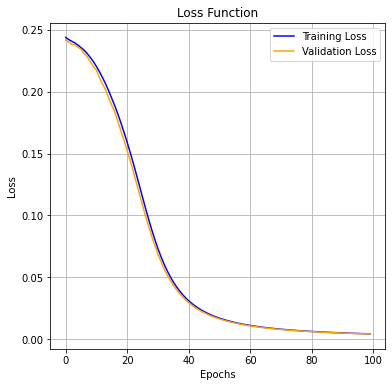

In [8]:
XOR_Model.PlotLoss()

Model is converging after 80 epochs. No underfitting or overfitting is observed.

Parameters of the Model

In [9]:
XOR_Model.PrintParameters()

self.W1 [[5.4639629  3.75822821]
 [5.43938799 3.76941543]]
self.b1 [[-2.26153013 -5.7726783 ]]
self.A1 [[ 3.22539254 -1.9703825 ]
 [ 3.07533109 -2.10252413]
 [-2.25803532 -5.77029316]
 [-2.1846827  -5.71911149]
 [ 8.61115245  1.733907  ]
 [ 8.5321531   1.67926574]
 [ 3.17368978 -2.03414318]
 [-2.4160298  -5.87928523]]
self.H1 [[0.96177874 0.12234781]
 [0.95586363 0.10885173]
 [0.0946586  0.00310915]
 [0.10113445 0.00327189]
 [0.99981797 0.84991149]
 [0.99980301 0.84280728]
 [0.95983208 0.11566446]
 [0.08195848 0.00278898]]
self.W2 [[ 7.16844771]
 [-7.66526517]]
self.b2 [[-3.26711318]]
self.A2 [[ 2.68951904]
 [ 2.75056789]
 [-2.61239035]
 [-2.56721606]
 [-2.61476726]
 [-2.56041886]
 [ 2.7267942 ]
 [-2.70097638]]
self.H2 [[0.93640535]
 [0.93994541]
 [0.06834524]
 [0.07127837]
 [0.06819405]
 [0.07172965]
 [0.93858932]
 [0.06291577]]
self.dW1 [[-0.00022786 -0.00038378]
 [-0.00102497  0.00176327]]
self.db1 [[0.00014212 0.00244538]]
self.dA1 [[-2.37971319e-04  7.46596676e-04]
 [ 1.52571189e-

### 1b: AND

- Generating Data
- Setting Training Parameters
- Creating Model

In [10]:
# Generating Data
X_Train, y_Train, X_Valid, y_Valid = GenerateDatasets(2500, "AND", 0.2)

# Training Data
batch_size = 8
epochs = 100
lr = 0.05

# Creating Model
AND_Model = MLP(2)

Training Model

In [11]:
AND_Model.fit(
	X_Train,
	y_Train,
	epochs,
	batch_size,
	lr,
	(X_Valid, y_Valid)
)

valid_step: 100%|██████████| 62/62 [00:00<00:00, 25166.64it/s]


Epoch: 1       loss: 0.20352      val_loss: 0.17661     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 30252.08it/s]


Epoch: 2       loss: 0.18361      val_loss: 0.17021     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 28595.43it/s]


Epoch: 3       loss: 0.17825      val_loss: 0.16508     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 20427.87it/s]


Epoch: 4       loss: 0.17237      val_loss: 0.15931     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 19415.17it/s]


Epoch: 5       loss: 0.16542      val_loss: 0.1524      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 23737.73it/s]


Epoch: 6       loss: 0.15741      val_loss: 0.14467     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 22487.62it/s]


Epoch: 7       loss: 0.14862      val_loss: 0.13644     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 21872.89it/s]


Epoch: 8       loss: 0.13941      val_loss: 0.12806     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 15080.42it/s]


Epoch: 9       loss: 0.13016      val_loss: 0.1194      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 24804.16it/s]


Epoch: 10      loss: 0.121        val_loss: 0.1109      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 15920.59it/s]


Epoch: 11      loss: 0.11203      val_loss: 0.10258     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 15278.90it/s]


Epoch: 12      loss: 0.10324      val_loss: 0.09447     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 21224.85it/s]


Epoch: 13      loss: 0.09486      val_loss: 0.08676     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 15562.35it/s]


Epoch: 14      loss: 0.08676      val_loss: 0.0792      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 18682.87it/s]


Epoch: 15      loss: 0.07914      val_loss: 0.07219     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 20177.44it/s]


Epoch: 16      loss: 0.07196      val_loss: 0.06575     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 20289.21it/s]


Epoch: 17      loss: 0.06537      val_loss: 0.05967     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 23685.84it/s]


Epoch: 18      loss: 0.0593       val_loss: 0.05413     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 20599.40it/s]


Epoch: 19      loss: 0.0538       val_loss: 0.04916     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 27335.95it/s]


Epoch: 20      loss: 0.04885      val_loss: 0.04466     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 21913.44it/s]


Epoch: 21      loss: 0.04441      val_loss: 0.04061     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 29443.71it/s]


Epoch: 22      loss: 0.04044      val_loss: 0.03703     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 35569.26it/s]


Epoch: 23      loss: 0.03691      val_loss: 0.03388     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 33330.79it/s]


Epoch: 24      loss: 0.03376      val_loss: 0.03104     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 29942.07it/s]


Epoch: 25      loss: 0.03096      val_loss: 0.02851     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34910.30it/s]


Epoch: 26      loss: 0.02847      val_loss: 0.02623     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 33433.64it/s]


Epoch: 27      loss: 0.02624      val_loss: 0.02424     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 31278.19it/s]


Epoch: 28      loss: 0.02426      val_loss: 0.02243     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 33335.07it/s]


Epoch: 29      loss: 0.0225       val_loss: 0.02082     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 43254.63it/s]


Epoch: 30      loss: 0.0209       val_loss: 0.01938     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 39641.29it/s]


Epoch: 31      loss: 0.01947      val_loss: 0.01809     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 39347.38it/s]


Epoch: 32      loss: 0.01819      val_loss: 0.01691     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 38040.79it/s]


Epoch: 33      loss: 0.01703      val_loss: 0.01586     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 27431.10it/s]


Epoch: 34      loss: 0.01598      val_loss: 0.01489     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 23927.76it/s]


Epoch: 35      loss: 0.01502      val_loss: 0.01402     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 40461.62it/s]


Epoch: 36      loss: 0.01416      val_loss: 0.01322     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 25242.37it/s]


Epoch: 37      loss: 0.01336      val_loss: 0.0125      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 26004.68it/s]


Epoch: 38      loss: 0.01264      val_loss: 0.01183     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 31624.33it/s]


Epoch: 39      loss: 0.01198      val_loss: 0.01123     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 35046.75it/s]


Epoch: 40      loss: 0.01137      val_loss: 0.01066     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 40887.87it/s]


Epoch: 41      loss: 0.01081      val_loss: 0.01014     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 44173.07it/s]


Epoch: 42      loss: 0.01029      val_loss: 0.00966     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 31585.92it/s]


Epoch: 43      loss: 0.00981      val_loss: 0.00923     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 30319.09it/s]


Epoch: 44      loss: 0.00937      val_loss: 0.00882     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 37579.02it/s]


Epoch: 45      loss: 0.00896      val_loss: 0.00843     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 39593.00it/s]


Epoch: 46      loss: 0.00858      val_loss: 0.00808     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 37112.44it/s]


Epoch: 47      loss: 0.00822      val_loss: 0.00775     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 38377.63it/s]


Epoch: 48      loss: 0.00789      val_loss: 0.00744     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 41620.81it/s]


Epoch: 49      loss: 0.00758      val_loss: 0.00715     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 38708.97it/s]


Epoch: 50      loss: 0.00729      val_loss: 0.00688     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 33502.56it/s]


Epoch: 51      loss: 0.00701      val_loss: 0.00662     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 29251.61it/s]


Epoch: 52      loss: 0.00676      val_loss: 0.00639     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 27193.02it/s]


Epoch: 53      loss: 0.00652      val_loss: 0.00616     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 31713.03it/s]


Epoch: 54      loss: 0.00629      val_loss: 0.00595     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 26817.25it/s]


Epoch: 55      loss: 0.00608      val_loss: 0.00575     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 26505.64it/s]


Epoch: 56      loss: 0.00587      val_loss: 0.00556     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 31467.43it/s]


Epoch: 57      loss: 0.00568      val_loss: 0.00538     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 26950.65it/s]


Epoch: 58      loss: 0.0055       val_loss: 0.00521     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 33667.38it/s]


Epoch: 59      loss: 0.00533      val_loss: 0.00505     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 37918.76it/s]


Epoch: 60      loss: 0.00517      val_loss: 0.0049      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 22628.51it/s]


Epoch: 61      loss: 0.00502      val_loss: 0.00476     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 19344.41it/s]


Epoch: 62      loss: 0.00487      val_loss: 0.00462     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 22410.10it/s]


Epoch: 63      loss: 0.00473      val_loss: 0.00449     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 14136.05it/s]


Epoch: 64      loss: 0.0046       val_loss: 0.00436     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 19524.50it/s]


Epoch: 65      loss: 0.00447      val_loss: 0.00425     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 18269.41it/s]


Epoch: 66      loss: 0.00435      val_loss: 0.00413     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 17323.75it/s]


Epoch: 67      loss: 0.00424      val_loss: 0.00402     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 20895.69it/s]


Epoch: 68      loss: 0.00413      val_loss: 0.00392     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 22699.62it/s]


Epoch: 69      loss: 0.00402      val_loss: 0.00382     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 24255.84it/s]


Epoch: 70      loss: 0.00392      val_loss: 0.00373     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 19353.04it/s]


Epoch: 71      loss: 0.00382      val_loss: 0.00364     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 25052.68it/s]


Epoch: 72      loss: 0.00373      val_loss: 0.00355     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 18694.96it/s]


Epoch: 73      loss: 0.00364      val_loss: 0.00347     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 17915.73it/s]


Epoch: 74      loss: 0.00356      val_loss: 0.00339     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 25663.36it/s]


Epoch: 75      loss: 0.00348      val_loss: 0.00331     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 25567.48it/s]


Epoch: 76      loss: 0.0034       val_loss: 0.00323     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 25454.86it/s]


Epoch: 77      loss: 0.00332      val_loss: 0.00316     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 21160.94it/s]


Epoch: 78      loss: 0.00325      val_loss: 0.00309     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 19345.84it/s]


Epoch: 79      loss: 0.00318      val_loss: 0.00303     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 25372.90it/s]


Epoch: 80      loss: 0.00311      val_loss: 0.00296     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 24089.56it/s]


Epoch: 81      loss: 0.00305      val_loss: 0.0029      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 30475.43it/s]


Epoch: 82      loss: 0.00298      val_loss: 0.00284     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 31046.66it/s]


Epoch: 83      loss: 0.00292      val_loss: 0.00279     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 35146.22it/s]


Epoch: 84      loss: 0.00287      val_loss: 0.00273     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 26676.94it/s]


Epoch: 85      loss: 0.00281      val_loss: 0.00268     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 33979.73it/s]


Epoch: 86      loss: 0.00276      val_loss: 0.00263     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 36901.78it/s]


Epoch: 87      loss: 0.0027       val_loss: 0.00258     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 40405.04it/s]


Epoch: 88      loss: 0.00265      val_loss: 0.00253     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 39258.28it/s]


Epoch: 89      loss: 0.0026       val_loss: 0.00248     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 33399.29it/s]


Epoch: 90      loss: 0.00255      val_loss: 0.00244     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 33975.29it/s]


Epoch: 91      loss: 0.00251      val_loss: 0.00239     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 29493.80it/s]


Epoch: 92      loss: 0.00246      val_loss: 0.00235     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 40099.75it/s]


Epoch: 93      loss: 0.00242      val_loss: 0.00231     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 41023.32it/s]


Epoch: 94      loss: 0.00238      val_loss: 0.00227     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 36724.59it/s]


Epoch: 95      loss: 0.00234      val_loss: 0.00223     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 40348.62it/s]


Epoch: 96      loss: 0.0023       val_loss: 0.0022      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 21271.73it/s]


Epoch: 97      loss: 0.00226      val_loss: 0.00216     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 29540.71it/s]


Epoch: 98      loss: 0.00222      val_loss: 0.00212     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 23287.08it/s]


Epoch: 99      loss: 0.00219      val_loss: 0.00209     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 27122.12it/s]

Epoch: 100     loss: 0.00215      val_loss: 0.00206     



Plotting Loss

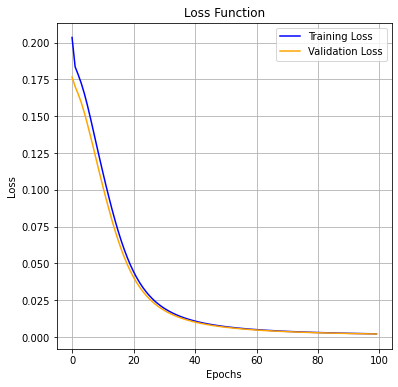

In [12]:
AND_Model.PlotLoss()

Model is converging after 60 epochs. No underfitting or overfitting is observed.

Parameters of the Model

In [13]:
AND_Model.PrintParameters()

self.W1 [[-3.40140251 -2.29431519]
 [-1.21794556 -3.90987566]]
self.b1 [[2.36109393 3.94508943]]
self.A1 [[ 1.13890021e+00  5.50254097e-02]
 [ 2.36912555e+00  3.91360979e+00]
 [ 1.11236150e+00 -1.04328742e-03]
 [ 2.36810347e+00  3.98820892e+00]
 [-1.01322620e+00  1.68132422e+00]
 [-1.05590786e+00  1.58692142e+00]
 [ 1.13490484e+00  3.59747659e-02]
 [-1.01241857e+00  1.72066862e+00]]
self.H1 [[0.75747766 0.51375288]
 [0.91444247 0.98042264]
 [0.75256911 0.49973918]
 [0.91436247 0.98180434]
 [0.26634895 0.8430798 ]
 [0.25809224 0.83018253]
 [0.75674293 0.50899272]
 [0.2665068  0.84821494]]
self.W2 [[-4.7373722 ]
 [-6.49256503]]
self.b2 [[3.63294508]]
self.A2 [[-3.29108253]
 [-7.06456699]
 [-3.17684399]
 [-7.0731588 ]
 [-3.10259947]
 [-2.97974799]
 [-3.2566962 ]
 [-3.13668748]]
self.H2 [[0.03587838]
 [0.00085413]
 [0.04004648]
 [0.00084683]
 [0.04300016]
 [0.04834922]
 [0.03708701]
 [0.04161905]]
self.dW1 [[ 5.62742598e-04  9.70705373e-04]
 [ 2.52970622e-04 -2.21114283e-05]]
self.db1 [[-0

### 1c: OR

- Generating Data
- Setting Training Parameters
- Creating Model

In [14]:
# Generating Data
X_Train, y_Train, X_Valid, y_Valid = GenerateDatasets(2500, "OR", 0.2)

# Training Data
batch_size = 8
epochs = 100
lr = 0.05

# Creating Model
OR_Model = MLP(2)

Training Model

In [15]:
OR_Model.fit(
	X_Train,
	y_Train,
	epochs,
	batch_size,
	lr,
	(X_Valid, y_Valid)
)

valid_step: 100%|██████████| 62/62 [00:00<00:00, 28849.22it/s]


Epoch: 1       loss: 0.29496      val_loss: 0.18625     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 31210.62it/s]


Epoch: 2       loss: 0.18978      val_loss: 0.17369     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 33425.04it/s]


Epoch: 3       loss: 0.18133      val_loss: 0.16558     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 35794.47it/s]


Epoch: 4       loss: 0.17161      val_loss: 0.15591     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 30521.93it/s]


Epoch: 5       loss: 0.15934      val_loss: 0.14356     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 30241.52it/s]


Epoch: 6       loss: 0.14448      val_loss: 0.12868     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 37687.95it/s]


Epoch: 7       loss: 0.1277       val_loss: 0.11333     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 33480.99it/s]


Epoch: 8       loss: 0.11029      val_loss: 0.0971      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 39550.85it/s]


Epoch: 9       loss: 0.09339      val_loss: 0.08151     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 39163.68it/s]


Epoch: 10      loss: 0.07829      val_loss: 0.06831     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 32408.63it/s]


Epoch: 11      loss: 0.06537      val_loss: 0.0572      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 41310.06it/s]


Epoch: 12      loss: 0.05472      val_loss: 0.04823     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 41761.18it/s]


Epoch: 13      loss: 0.04614      val_loss: 0.04087     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 38377.63it/s]


Epoch: 14      loss: 0.03926      val_loss: 0.03494     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 32726.76it/s]


Epoch: 15      loss: 0.03374      val_loss: 0.03017     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 22338.88it/s]


Epoch: 16      loss: 0.02928      val_loss: 0.0263      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 16552.95it/s]


Epoch: 17      loss: 0.02567      val_loss: 0.02318     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 22620.64it/s]


Epoch: 18      loss: 0.0227       val_loss: 0.0206      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 22669.94it/s]


Epoch: 19      loss: 0.02024      val_loss: 0.01846     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 21763.06it/s]


Epoch: 20      loss: 0.01819      val_loss: 0.01665     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 20219.80it/s]


Epoch: 21      loss: 0.01645      val_loss: 0.01511     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 20645.19it/s]


Epoch: 22      loss: 0.01497      val_loss: 0.0138      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 24616.32it/s]


Epoch: 23      loss: 0.0137       val_loss: 0.01268     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 25709.03it/s]


Epoch: 24      loss: 0.01261      val_loss: 0.01169     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 22460.43it/s]


Epoch: 25      loss: 0.01165      val_loss: 0.01082     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 23561.37it/s]


Epoch: 26      loss: 0.01082      val_loss: 0.01006     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 20583.10it/s]


Epoch: 27      loss: 0.01008      val_loss: 0.0094      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 24863.45it/s]


Epoch: 28      loss: 0.00942      val_loss: 0.0088      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 22287.18it/s]


Epoch: 29      loss: 0.00884      val_loss: 0.00826     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 24235.49it/s]


Epoch: 30      loss: 0.00831      val_loss: 0.00778     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 19153.48it/s]


Epoch: 31      loss: 0.00784      val_loss: 0.00735     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 19772.42it/s]


Epoch: 32      loss: 0.00741      val_loss: 0.00696     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 25903.66it/s]


Epoch: 33      loss: 0.00702      val_loss: 0.0066      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 19511.32it/s]


Epoch: 34      loss: 0.00667      val_loss: 0.00628     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 16537.16it/s]


Epoch: 35      loss: 0.00634      val_loss: 0.00598     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 23918.95it/s]


Epoch: 36      loss: 0.00605      val_loss: 0.0057      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 28801.29it/s]


Epoch: 37      loss: 0.00578      val_loss: 0.00545     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 33724.14it/s]


Epoch: 38      loss: 0.00552      val_loss: 0.00521     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 35829.00it/s]


Epoch: 39      loss: 0.00529      val_loss: 0.005       



valid_step: 100%|██████████| 62/62 [00:00<00:00, 40298.60it/s]


Epoch: 40      loss: 0.00508      val_loss: 0.0048      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 30969.02it/s]


Epoch: 41      loss: 0.00488      val_loss: 0.00461     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34924.37it/s]


Epoch: 42      loss: 0.00469      val_loss: 0.00444     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 37698.88it/s]


Epoch: 43      loss: 0.00451      val_loss: 0.00428     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34682.16it/s]


Epoch: 44      loss: 0.00435      val_loss: 0.00412     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 31543.77it/s]


Epoch: 45      loss: 0.0042       val_loss: 0.00398     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 37990.77it/s]


Epoch: 46      loss: 0.00406      val_loss: 0.00385     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 37309.45it/s]


Epoch: 47      loss: 0.00392      val_loss: 0.00372     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 37438.36it/s]


Epoch: 48      loss: 0.00379      val_loss: 0.0036      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34622.13it/s]


Epoch: 49      loss: 0.00367      val_loss: 0.00349     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 31139.61it/s]


Epoch: 50      loss: 0.00356      val_loss: 0.00338     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 33676.10it/s]


Epoch: 51      loss: 0.00345      val_loss: 0.00328     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 26462.49it/s]


Epoch: 52      loss: 0.00335      val_loss: 0.00319     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 40562.60it/s]


Epoch: 53      loss: 0.00326      val_loss: 0.0031      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 30647.83it/s]


Epoch: 54      loss: 0.00317      val_loss: 0.00301     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34910.30it/s]


Epoch: 55      loss: 0.00308      val_loss: 0.00293     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 32821.77it/s]


Epoch: 56      loss: 0.003        val_loss: 0.00285     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 27944.00it/s]


Epoch: 57      loss: 0.00292      val_loss: 0.00278     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34691.42it/s]


Epoch: 58      loss: 0.00284      val_loss: 0.00271     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 35322.85it/s]


Epoch: 59      loss: 0.00277      val_loss: 0.00264     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 29497.15it/s]


Epoch: 60      loss: 0.0027       val_loss: 0.00258     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34475.25it/s]


Epoch: 61      loss: 0.00264      val_loss: 0.00252     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 37655.21it/s]


Epoch: 62      loss: 0.00258      val_loss: 0.00246     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 31833.38it/s]


Epoch: 63      loss: 0.00252      val_loss: 0.0024      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 33051.20it/s]


Epoch: 64      loss: 0.00246      val_loss: 0.00235     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 33395.00it/s]


Epoch: 65      loss: 0.00241      val_loss: 0.00229     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 31798.34it/s]


Epoch: 66      loss: 0.00235      val_loss: 0.00224     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 28495.16it/s]


Epoch: 67      loss: 0.0023       val_loss: 0.0022      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 37395.29it/s]


Epoch: 68      loss: 0.00225      val_loss: 0.00215     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34686.79it/s]


Epoch: 69      loss: 0.00221      val_loss: 0.00211     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34311.50it/s]


Epoch: 70      loss: 0.00216      val_loss: 0.00206     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 30586.55it/s]


Epoch: 71      loss: 0.00212      val_loss: 0.00202     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 36127.65it/s]


Epoch: 72      loss: 0.00208      val_loss: 0.00198     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 36228.32it/s]


Epoch: 73      loss: 0.00204      val_loss: 0.00194     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 29658.63it/s]


Epoch: 74      loss: 0.002        val_loss: 0.00191     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 32188.00it/s]


Epoch: 75      loss: 0.00196      val_loss: 0.00187     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 35438.38it/s]


Epoch: 76      loss: 0.00192      val_loss: 0.00184     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 39122.44it/s]


Epoch: 77      loss: 0.00189      val_loss: 0.0018      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 30752.94it/s]


Epoch: 78      loss: 0.00185      val_loss: 0.00177     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34325.09it/s]


Epoch: 79      loss: 0.00182      val_loss: 0.00174     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 35559.53it/s]


Epoch: 80      loss: 0.00179      val_loss: 0.00171     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34212.19it/s]


Epoch: 81      loss: 0.00176      val_loss: 0.00168     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 33377.85it/s]


Epoch: 82      loss: 0.00173      val_loss: 0.00165     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 37720.75it/s]


Epoch: 83      loss: 0.0017       val_loss: 0.00163     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34100.03it/s]


Epoch: 84      loss: 0.00167      val_loss: 0.0016      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34498.12it/s]


Epoch: 85      loss: 0.00164      val_loss: 0.00157     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 35294.09it/s]


Epoch: 86      loss: 0.00162      val_loss: 0.00155     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34691.42it/s]


Epoch: 87      loss: 0.00159      val_loss: 0.00152     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 30259.12it/s]


Epoch: 88      loss: 0.00157      val_loss: 0.0015      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34470.69it/s]


Epoch: 89      loss: 0.00154      val_loss: 0.00148     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 31817.80it/s]


Epoch: 90      loss: 0.00152      val_loss: 0.00146     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 31361.17it/s]


Epoch: 91      loss: 0.0015       val_loss: 0.00143     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 29353.97it/s]


Epoch: 92      loss: 0.00148      val_loss: 0.00141     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 15249.33it/s]


Epoch: 93      loss: 0.00145      val_loss: 0.00139     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 22885.40it/s]


Epoch: 94      loss: 0.00143      val_loss: 0.00137     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 23969.66it/s]


Epoch: 95      loss: 0.00141      val_loss: 0.00135     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 35696.20it/s]


Epoch: 96      loss: 0.00139      val_loss: 0.00133     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 36621.16it/s]


Epoch: 97      loss: 0.00137      val_loss: 0.00131     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 34370.45it/s]


Epoch: 98      loss: 0.00135      val_loss: 0.0013      



valid_step: 100%|██████████| 62/62 [00:00<00:00, 26939.48it/s]


Epoch: 99      loss: 0.00134      val_loss: 0.00128     



valid_step: 100%|██████████| 62/62 [00:00<00:00, 28693.24it/s]

Epoch: 100     loss: 0.00132      val_loss: 0.00126     



Plotting Loss

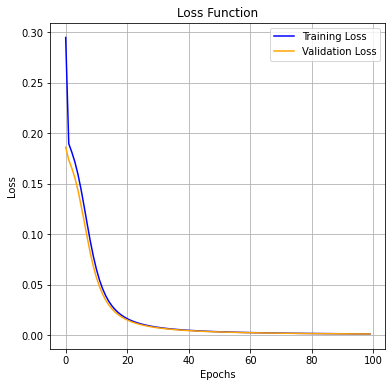

In [16]:
OR_Model.PlotLoss()

Model is converging after 40 epochs. No underfitting or overfitting is observed.

Parameters of the Model

In [17]:
OR_Model.PrintParameters()

self.W1 [[-4.55225898  0.02435338]
 [-4.03510827  1.84724847]]
self.b1 [[ 1.94928011 -0.23029808]]
self.A1 [[-2.6580175  -0.18619833]
 [ 1.97738901 -0.24649867]
 [-2.56486151 -0.21543182]
 [-2.15685665  1.63745372]
 [-2.10586195  1.61575846]
 [-2.70224886 -0.17779735]
 [-2.02772069  1.60655884]
 [-2.10781859  1.62848723]]
self.H1 [[0.06549657 0.45358444]
 [0.87840255 0.43868548]
 [0.0714344  0.44634938]
 [0.10369223 0.83718817]
 [0.10852837 0.83420934]
 [0.06284079 0.45566739]
 [0.11632301 0.83293308]
 [0.10833922 0.8359623 ]]
self.W2 [[-7.61114406]
 [ 1.63003611]]
self.b2 [[2.91010905]]
self.A2 [[ 3.15096423]
 [-3.06046615]
 [ 3.09397716]
 [ 3.48553948]
 [ 3.4438753 ]
 [ 3.17457306]
 [ 3.38246884]
 [ 3.4481724 ]]
self.H2 [[0.9589467 ]
 [0.04476776]
 [0.95664362]
 [0.97027351]
 [0.96904796]
 [0.95986612]
 [0.96715213]
 [0.96917659]]
self.dW1 [[ 0.00020815 -0.0001846 ]
 [ 0.00035153 -0.00011439]]
self.db1 [[-0.00121268  0.00055381]]
self.dA1 [[ 1.70061458e-04 -5.12778311e-05]
 [ 4.72949